In [1]:
"""
Author: Amruth Karun M V
Date: 20-Oct-2021
"""

import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Input, GlobalAveragePooling2D)
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

TRAIN_PATH = "../input/covid19/"
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001
INPUT_SIZE = (224, 224)

def load_data():
    """
    Loads input data from directory
    Arguments: None
    Returns: Train and val generator
    """
    
    train_datagen =  keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                                 ) # set validation split

    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=INPUT_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='categorical',
        subset='training') # set as training data

    validation_generator = train_datagen.flow_from_directory(
        TRAIN_PATH, 
        target_size=INPUT_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='categorical',
        subset='validation') # set as validation data
    
    return train_generator, validation_generator


def load_model():
    """
    Creates a keras ResNet-50 model
    Arguments: None
    Returns: ResNet-50 Model
    """
    
    input_layer = Input(shape=(224, 224, 3))
    
    # Load ResNet50 model from keras using imagenet weights for transfer learning
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x) 
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x, name='ResNet50')
    model.summary()
    
    opt = Adam(learning_rate=LEARNING_RATE)
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    
    return model    
    

def plot_curves(history):
    """
    Plots loss and accuracy and loss plots for
    training and validation datasets
    Arguments: 
        history -- training history
    Returns: None
    """
   
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="Validation loss")
    plt.legend()
    plt.title('Training Loss VS Validation Loss')
    plt.show()
    
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.title('Training Accuracy VS Validation Accuracy')
    plt.legend()
    plt.show()
    

def get_confusion_matrix(model, data_generator):
    """
    Calculates the accuracy and displays the 
    confusion matrix for the input data
    Arguments:
        model           -- trained model
        data_generator  -- input data generator
    Returns: None
    """
    
    predictions = model.predict(data_generator, BATCH_SIZE)
    y_pred = np.argmax(predictions, axis=1)
    y_true = data_generator.classes
    class_names = ['COVID', 'Normal', 'Pneumonia']
    
    print("Score =", model.evaluate(data_generator, batch_size=BATCH_SIZE))
    print("Accuracy  = ", metrics.accuracy_score(y_true, y_pred))
    cm = metrics.confusion_matrix(y_true, y_pred)
    metrics.ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap=plt.cm.Blues,
                                                                       xticks_rotation='vertical')
    plt.show()

    
def train_model(train_generator, val_generator):
    """
    Trains ResNet-50 model and saves the 
    trained weights to an H5 file.
    Arguments: 
        train_generator   -- train data generator
        val_generator     -- validation data generator
    Returns: Trained model
    """
    
    # Loads the model
    model = load_model()
    earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    callbacks = [earlystop]
    
    history = model.fit(
        train_generator, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//BATCH_SIZE,
        steps_per_epoch=train_generator.samples//BATCH_SIZE,
        callbacks=callbacks)
    
    plot_curves(history)
    model.save_weights("model_resnet50.h5")
    print("Model saved successfully!")
    
    return model


Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


2021-10-20 16:19:20.932076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 16:19:21.026761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 16:19:21.027653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 16:19:21.029020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step
Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

2021-10-20 16:19:26.132916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-10-20 16:19:30.752840: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 113s 1s/step - loss: 1.1376 - accuracy: 0.6874 - val_loss: 0.3460 - val_accuracy: 0.8665
Epoch 2/50
94/94 [==============================] - 66s 707ms/step - loss: 0.4359 - accuracy: 0.8272 - val_loss: 0.4494 - val_accuracy: 0.8108
Epoch 3/50
94/94 [==============================] - 66s 707ms/step - loss: 0.3353 - accuracy: 0.8622 - val_loss: 0.2493 - val_accuracy: 0.9154
Epoch 4/50
94/94 [==============================] - 67s 707ms/step - loss: 0.2782 - accuracy: 0.8888 - val_loss: 0.2914 - val_accuracy: 0.8801
Epoch 5/50
94/94 [==============================] - 67s 709ms/step - loss: 0.2410 - accuracy: 0.9059 - val_loss: 0.2913 - val_accuracy: 0.8910
Epoch 6/50
94/94 [==============================] - 66s 705ms/step - loss: 0.2181 - accuracy: 0.9200 - val_loss: 0.1927 - val_accuracy: 0.9327
Epoch 7/50
94/94 [==============================] - 67s 712ms/step - loss: 0.1926 - accuracy: 0.9280 - val_loss: 0.1634 - val_accuracy: 0.9378
Epoch 8/50
9

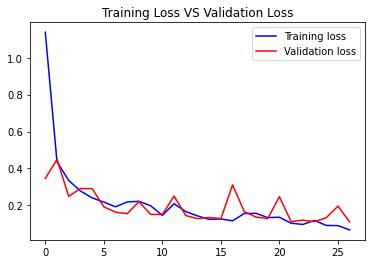

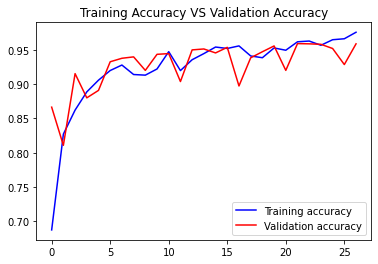

Model saved successfully!
Confusion matrix for train data:
95/95 [==============================] - 54s 564ms/step - loss: 0.0542 - accuracy: 0.9810
Score = [0.05423067882657051, 0.9810277819633484]
Accuracy  =  0.9810277983997361


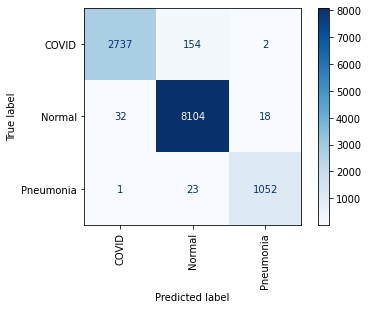

Confusion matrix for val/test data:
24/24 [==============================] - 13s 547ms/step - loss: 0.1101 - accuracy: 0.9591
Score = [0.11012284457683563, 0.959075927734375]
Accuracy  =  0.9590759075907591


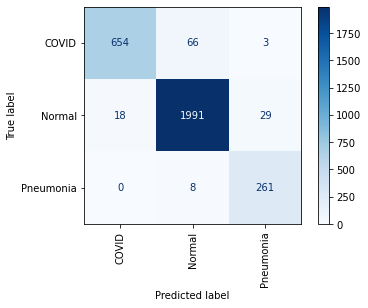

In [2]:
train_generator, val_generator = load_data()
model = train_model(train_generator, val_generator)

print("Confusion matrix for train data:")
get_confusion_matrix(model, train_generator)

print("Confusion matrix for val/test data:")
get_confusion_matrix(model, val_generator)